#Histopathology Dataset

### Acquiring Histopathology Dataset

In [8]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import os

%matplotlib inline

!pip install ipython-autotime
%load_ext autotime

Using TensorFlow backend.


  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [6]:
# Download dataset from Kimia Labs

!mkdir -p /content/hist/
!wget http://kimia.uwaterloo.ca/kimia_data/KIMIA_Path_960.zip -P /content/
!unzip /content/KIMIA_Path_960.zip -d /content/hist
!rm /content/KIMIA_Path_960.zip

--2019-05-09 18:44:34--  http://kimia.uwaterloo.ca/kimia_data/KIMIA_Path_960.zip
Resolving kimia.uwaterloo.ca (kimia.uwaterloo.ca)... 129.97.229.10
Connecting to kimia.uwaterloo.ca (kimia.uwaterloo.ca)|129.97.229.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128755694 (123M) [application/zip]
Saving to: ‘/content/KIMIA_Path_960.zip’

KIMIA_Path_960.zip  100%[===================>] 122.79M  4.58MB/s    in 27s     

2019-05-09 18:45:01 (4.53 MB/s) - ‘/content/KIMIA_Path_960.zip’ saved [128755694/128755694]

Archive:  /content/KIMIA_Path_960.zip
mapname:  conversion of  failed
  inflating: /content/hist/A5.tif    
  inflating: /content/hist/K25.tif   
  inflating: /content/hist/C38.tif   
  inflating: /content/hist/L29.tif   
  inflating: /content/hist/D34.tif   
  inflating: /content/hist/T46.tif   
  inflating: /content/hist/P42.tif   
  inflating: /content/hist/O21.tif   
  inflating: /content/hist/Q16.tif   
  inflating: /content/hist/H38.tif   
  inflatin

In [15]:
# Reading images and parsing labels from image names

from os import listdir

image_dir = '/content/hist/'

images = []
labels = []

for file in os.listdir(image_dir):
  _, ext = os.path.splitext(file)
  if ext != '.tif':
    continue
  
  path = os.path.join(image_dir, file)
  img = plt.imread(path)
  images.append(img)
  
  # Images are labelled into classes A-T
  label = ord(file[0]) - ord('A')
  labels.append(label)

time: 1.3 s


In [22]:
def convertOneHot(labels, num_classes):
  return np.array([np.eye(num_classes)[label] for label in labels])

# Normalize images
X = np.array(images)/255

# Convert labels to one hot
num_classes = max(labels) + 1
Classes = np.unique(labels)
Y = convertOneHot(labels, num_classes)

print(X.shape)
print(Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

(960, 168, 308, 3)
(960, 20)
time: 1.24 s


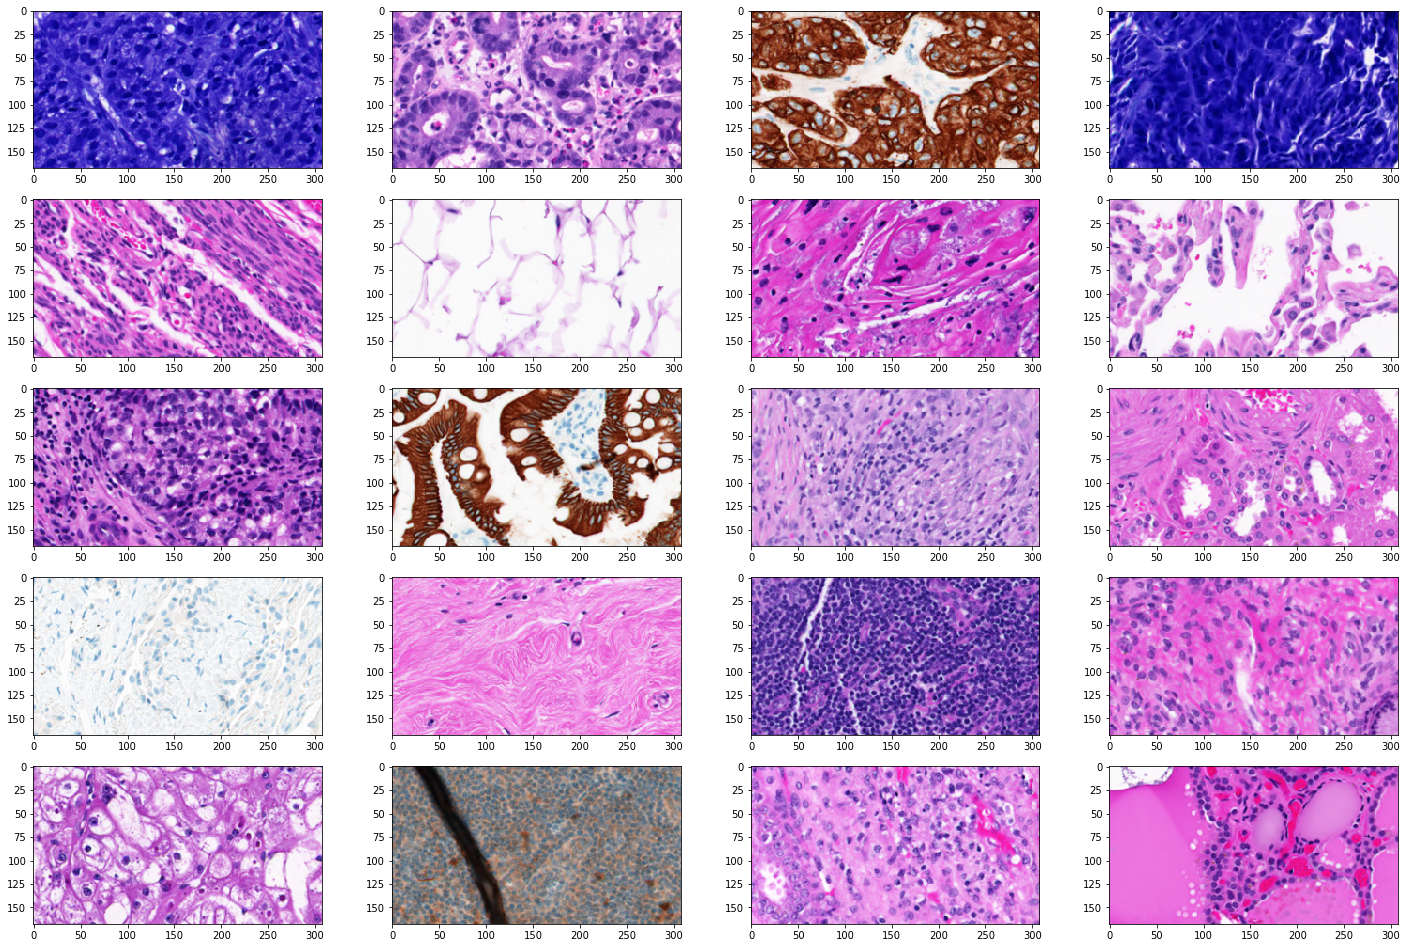

time: 3.5 s


In [21]:
# Profiling images
Label_map = {}
for i, y in enumerate(labels):
  if y in Label_map:
    Label_map[y].append(i)
  else:
    Label_map[y] = [i]

# View 12 random images with specific label
rows = 5
columns = 4
scale_factor = 50

def ShowImages():
  # Doesn't actually shuffle the training set
  figsize_x = X[0].shape[1] * columns / scale_factor
  figsize_y = X[0].shape[0] * rows / scale_factor
  fig = plt.figure(figsize=(figsize_x, figsize_y))
  for i in range(1, columns*rows +1):
    np.random.shuffle(Label_map[i - 1])
    fig.add_subplot(rows, columns, i)
    img_index = Label_map[i - 1][0]
    plt.imshow(X[img_index])
  plt.show()

ShowImages()

# Single Classifier

In [23]:
# Method that builds and trains a CNN.
def build_and_train(x_train, y_train, model=None, epochs=25):
  # Randomly break off data for validation
  x_t, x_v, y_t, y_v = train_test_split(x_train, y_train)
  
  # Performing image augmentations
  # Augmentations chosen based on research and empirical experimentation
  train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
  )

  # Use standardized CNN architecture if one is not specified.
  if model == None:
    model = keras.Sequential([
        keras.layers.Conv2D(16, (3, 3), activation='relu', \
                            input_shape=x_train[0].shape),
        keras.layers.Conv2D(16, (3, 3), activation='relu'),
        keras.layers.BatchNormalization(momentum=0.1),
        keras.layers.MaxPool2D((2, 2)),

        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.BatchNormalization(momentum=0.1),
        keras.layers.MaxPool2D((2, 2)),

        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPool2D((2, 2)),

        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(y_train[0].shape[0]),
    ]);
  
  # Training model and save the one with best validation accuracy
  Best_model = 'best_model.h5'
  
  optimizer = tf.train.AdamOptimizer()
  model.compile(optimizer=optimizer, loss=tf.losses.softmax_cross_entropy, \
                metrics=['accuracy'])

  # Set callback functions to early stop training and save the best model so far
  callbacks = [keras.callbacks.ModelCheckpoint(filepath=Best_model, \
                                               monitor='val_acc', \
                                               save_best_only=True)]
  
  model.fit_generator(
    train_datagen.flow(x_t, y_t, batch_size=32),
    steps_per_epoch=len(x_t)/8,
    epochs=epochs,
    validation_data=(x_v, y_v),
    callbacks=callbacks,
  )
  
  best = keras.models.load_model(Best_model)
  best.compile(optimizer=optimizer, loss=tf.losses.softmax_cross_entropy, \
               metrics=['accuracy'])
  return best

time: 35.2 ms


In [24]:
best = build_and_train(X_train, Y_train)

# Evaluate models
results = best.evaluate(X_test, Y_test)
print(best.metrics_names)
print(results)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
68/67 [==============================] - 25s 365ms/step - loss: 3.3621 - acc: 0.2000 - val_loss: 2.0779 - val_acc: 0.3333
Epoch 2/25
 1/67 [..............................] - ETA: 3s - loss: 2.2097 - acc: 0.3438

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:118: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


68/67 [==============================] - 22s 330ms/step - loss: 1.9767 - acc: 0.3757 - val_loss: 1.7871 - val_acc: 0.3667
Epoch 3/25
68/67 [==============================] - 23s 332ms/step - loss: 1.7511 - acc: 0.4382 - val_loss: 1.5569 - val_acc: 0.4611
Epoch 4/25
68/67 [==============================] - 23s 334ms/step - loss: 1.6187 - acc: 0.4722 - val_loss: 2.0937 - val_acc: 0.4444
Epoch 5/25
68/67 [==============================] - 22s 327ms/step - loss: 1.5702 - acc: 0.4903 - val_loss: 1.3333 - val_acc: 0.5278
Epoch 6/25
68/67 [==============================] - 23s 337ms/step - loss: 1.4223 - acc: 0.5266 - val_loss: 1.2082 - val_acc: 0.5222
Epoch 7/25
68/67 [==============================] - 22s 323ms/step - loss: 1.2908 - acc: 0.5836 - val_loss: 1.2284 - val_acc: 0.5944
Epoch 8/25
68/67 [==============================] - 23s 339ms/step - loss: 1.0687 - acc: 0.6620 - val_loss: 0.9864 - val_acc: 0.6611
Epoch 9/25
68/67 [==============================] - 22s 329ms/step - loss: 1.030

KeyboardInterrupt: ignored

time: 4min 10s


Confusion matrix, without normalization
[[ 6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  1  9  0  0  0  0  1  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  7  0  1  0  0  0  0  0  1  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  2  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  7  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0]
 [ 0  0  0  0  

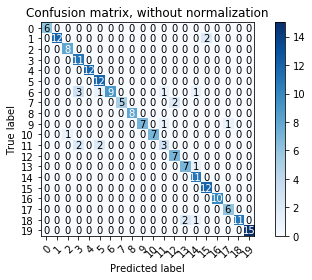

time: 2.96 s


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
  
Y_pred = best.predict(X_test, batch_size=1)
plot_confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1), Classes)

plt.show()

# Classifier Tree

In [25]:
def buildClassDict(class_groups):
  class_dict = {}
  for i, group in enumerate(class_groups):
    for val in group:
      class_dict[val] = i
  return class_dict

def remapAndFilter(data, labels, class_dict, class_groups):
  new_labels = []
  new_data = []
  for idx, label in enumerate(labels):
    label = np.argmax(label)
    
    if label in class_dict:
      new_label = class_dict[label]
      new_labels.append(new_label)
      new_data.append(data[idx])
  
  return np.array(new_data), convertOneHot(new_labels, len(class_groups))

time: 9.89 ms


In [26]:
Class_groups = [[0, 4, 7], [1, 15], [2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19], [16]]
Class_dict = buildClassDict(Class_groups)

remapped_x_train, remapped_y_train = remapAndFilter(X_train, Y_train, Class_dict, Class_groups)
remapped_x_test, remapped_y_test = remapAndFilter(X_test, Y_test, Class_dict, Class_groups)

root = build_and_train(remapped_x_train, remapped_y_train)

# Evaluate model
results = root.evaluate(remapped_x_test, remapped_y_test)
print(root.metrics_names)
print(results)

Epoch 1/25
22/67 [========>.....................] - ETA: 15s - loss: 7.9572 - acc: 0.5712

KeyboardInterrupt: ignored

time: 9.84 s


In [0]:
White_groups = [[x] for x in Class_groups[0]]
White_dict = buildClassDict(White_groups)

remapped_x_train, remapped_y_train = remapAndFilter(X_train, Y_train, White_dict, White_groups)
remapped_x_test, remapped_y_test = remapAndFilter(X_test, Y_test, White_dict, White_groups)

white = build_and_train(remapped_x_train, remapped_y_train)

# Evaluate model
results = white.evaluate(remapped_x_test, remapped_y_test)
print(white.metrics_names)
print(results)

Epoch 1/10
12/11 [================================] - 5s 448ms/step - loss: 9.4598 - acc: 0.5216 - val_loss: 2.8394 - val_acc: 0.5333
Epoch 2/10
 2/11 [====>.........................] - ETA: 0s - loss: 1.2610 - acc: 0.7656

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:118: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


12/11 [================================] - 1s 72ms/step - loss: 0.8751 - acc: 0.7381 - val_loss: 0.9041 - val_acc: 0.8000
Epoch 3/10
12/11 [================================] - 3s 280ms/step - loss: 0.4909 - acc: 0.8517 - val_loss: 0.9443 - val_acc: 0.7000
Epoch 4/10
12/11 [================================] - 4s 298ms/step - loss: 0.1520 - acc: 0.9436 - val_loss: 0.3419 - val_acc: 0.8333
Epoch 5/10
12/11 [================================] - 4s 296ms/step - loss: 0.1622 - acc: 0.9271 - val_loss: 0.3414 - val_acc: 0.8333
Epoch 6/10
12/11 [================================] - 4s 297ms/step - loss: 0.1555 - acc: 0.9338 - val_loss: 0.2700 - val_acc: 0.8667
Epoch 7/10
12/11 [================================] - 4s 308ms/step - loss: 0.1203 - acc: 0.9507 - val_loss: 0.2790 - val_acc: 0.8667
Epoch 8/10
12/11 [================================] - 4s 342ms/step - loss: 0.1656 - acc: 0.9416 - val_loss: 0.1141 - val_acc: 0.9000
Epoch 9/10
12/11 [================================] - 4s 340ms/step - loss

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


25/25 [==============================] - 2s 95ms/step
['loss', 'acc']
[0.01644480973482132, 1.0]
time: 45.8 s


In [0]:
Blue_groups = [[x] for x in Class_groups[1]]
Blue_dict = buildClassDict(Blue_groups)

remapped_x_train, remapped_y_train = remapAndFilter(X_train, Y_train, Blue_dict, Blue_groups)
remapped_x_test, remapped_y_test = remapAndFilter(X_test, Y_test, Blue_dict, Blue_groups)

blue = build_and_train(remapped_x_train, remapped_y_train)

# Evaluate model
results = blue.evaluate(remapped_x_test, remapped_y_test)
print(blue.metrics_names)
print(results)

Epoch 1/10
7/6 [================================] - 6s 795ms/step - loss: 12.9486 - acc: 0.5618 - val_loss: 8.3578 - val_acc: 0.6111
Epoch 2/10
2/6 [========>.....................] - ETA: 0s - loss: 1.2113 - acc: 0.9281

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:118: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


7/6 [================================] - 0s 70ms/step - loss: 1.5495 - acc: 0.9050 - val_loss: 0.2557 - val_acc: 0.9444
Epoch 3/10
7/6 [================================] - 1s 99ms/step - loss: 0.6224 - acc: 0.9013 - val_loss: 0.3475 - val_acc: 0.8889
Epoch 4/10
7/6 [================================] - 2s 246ms/step - loss: 0.8130 - acc: 0.9375 - val_loss: 0.0828 - val_acc: 0.9444
Epoch 5/10
7/6 [================================] - 2s 268ms/step - loss: 0.1817 - acc: 0.9290 - val_loss: 0.0082 - val_acc: 1.0000
Epoch 6/10
7/6 [================================] - 2s 251ms/step - loss: 0.0939 - acc: 0.9768 - val_loss: 3.3643e-06 - val_acc: 1.0000
Epoch 7/10
7/6 [================================] - 2s 273ms/step - loss: 0.0271 - acc: 0.9909 - val_loss: 8.0433e-05 - val_acc: 1.0000
Epoch 8/10
7/6 [================================] - 2s 250ms/step - loss: 0.0814 - acc: 0.9722 - val_loss: 4.5969e-05 - val_acc: 1.0000
Epoch 9/10
7/6 [================================] - 2s 272ms/step - loss: 0.0

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


26/26 [==============================] - 3s 127ms/step
['loss', 'acc']
[0.03480096161365509, 1.0]
time: 31.4 s


In [0]:
Pink_groups = [[x] for x in Class_groups[2]]
Pink_dict = buildClassDict(Pink_groups)

remapped_x_train, remapped_y_train = remapAndFilter(X_train, Y_train, Pink_dict, Pink_groups)
remapped_x_test, remapped_y_test = remapAndFilter(X_test, Y_test, Pink_dict, Pink_groups)

pink = build_and_train(remapped_x_train, remapped_y_train)

# Evaluate model
results = pink.evaluate(remapped_x_test, remapped_y_test)
print(pink.metrics_names)
print(results)

Epoch 1/10
50/49 [==============================] - 19s 371ms/step - loss: 5.1766 - acc: 0.2366 - val_loss: 1.7720 - val_acc: 0.3433
Epoch 2/10
 2/49 [>.............................] - ETA: 3s - loss: 1.8963 - acc: 0.3719

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:118: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


50/49 [==============================] - 12s 246ms/step - loss: 1.5190 - acc: 0.4718 - val_loss: 1.3664 - val_acc: 0.5224
Epoch 3/10
50/49 [==============================] - 15s 303ms/step - loss: 1.2771 - acc: 0.5522 - val_loss: 0.9610 - val_acc: 0.6716
Epoch 4/10
50/49 [==============================] - 17s 330ms/step - loss: 0.9068 - acc: 0.6973 - val_loss: 1.3317 - val_acc: 0.5448
Epoch 5/10
50/49 [==============================] - 15s 303ms/step - loss: 0.9842 - acc: 0.7050 - val_loss: 0.7087 - val_acc: 0.7985
Epoch 6/10
50/49 [==============================] - 15s 305ms/step - loss: 0.5839 - acc: 0.8137 - val_loss: 0.5712 - val_acc: 0.8134
Epoch 7/10
50/49 [==============================] - 15s 308ms/step - loss: 0.4468 - acc: 0.8574 - val_loss: 0.4500 - val_acc: 0.8657
Epoch 8/10
50/49 [==============================] - 15s 301ms/step - loss: 0.4405 - acc: 0.8697 - val_loss: 0.7822 - val_acc: 0.7836
Epoch 9/10
50/49 [==============================] - 16s 322ms/step - loss: 0.519

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


139/139 [==============================] - 4s 29ms/step
['loss', 'acc']
[0.26511332392692566, 0.9568345345181527]
time: 2min 50s


### Combining Individual Classifiers

In [0]:
from sklearn.metrics import accuracy_score
from scipy.special import softmax

def predict(x):
  y_root = root.predict(x)
  y_white = white.predict(x)
  y_blue = blue.predict(x)
  y_pink = pink.predict(x)
  
  y_pred = []
  
  for (y_r, y_w, y_p, y_b) in zip(y_root, y_white, y_pink, y_blue):
    # Normalize Predictions
    y_r = softmax(y_r)
    y_w = softmax(y_w)
    y_p = softmax(y_p)
    y_b = softmax(y_b)
    
    y = np.zeros(num_classes)
    y[16] = y_r[Class_dict[16]]
    
    for i in Class_groups[0]:
      y[i] = y_r[0] * y_w[White_dict[i]]
      
    for i in Class_groups[1]:
      y[i] = y_r[1] * y_b[Blue_dict[i]]
      
    for i in Class_groups[2]:
      y[i] = y_r[2] * y_p[Pink_dict[i]]
       
    y_pred.append(y)
 
  return y_pred

time: 11.8 ms


In [0]:
    
y_pred = predict(X_test)
y_labels = [np.argmax(pred) for pred in y_pred]

accuracy_score(y_test, y_labels)

In [0]:
from sklearn.metrics import accuracy_score
from scipy.special import softmax

def compare(x, y_true):
  y_root = root.predict(x)
  y_white = white.predict(x)
  y_blue = blue.predict(x)
  y_pink = pink.predict(x)
  
  y_pred = []
  
  for (y_r, y_w, y_p, y_b, y_T) in zip(y_root, y_white, y_pink, y_blue, y_true):
    # Normalize Predictions
    y_r = softmax(y_r)
    y_w = softmax(y_w)
    y_p = softmax(y_p)
    y_b = softmax(y_b)
    
    y = np.zeros(num_classes)
    y[16] = y_r[Class_dict[16]]
    
    for i in Class_groups[0]:
      y[i] = y_r[0] * y_w[White_dict[i]]
      
    for i in Class_groups[1]:
      y[i] = y_r[1] * y_b[Blue_dict[i]]
      
    for i in Class_groups[2]:
      y[i] = y_r[2] * y_p[Pink_dict[i]]
       
    y_pred.append(y)
    
    if np.argmax(y) != y_T:
      print("False Prediction: ", np.argmax(y))
      print("True Label:", y_T)
      print("Root: ", y_r)
      print("White: ", y_w)
      print("Blue: ", y_b)
      print("Pink: ", y_p)
      print("")
 
  return y_pred

y_pred = compare(X_test, y_test)

False Prediction:  2
True Label: 10
Root:  [0.000000e+00 1.856027e-39 1.000000e+00 0.000000e+00]
White:  [1.0000000e+00 1.3023722e-14 3.2873375e-09]
Blue:  [0.8077637  0.19223578]
Pink:  [6.20857894e-01 1.12642185e-04 2.84042212e-08 3.08036568e-10
 1.57475085e-07 4.17246036e-02 3.24646890e-01 1.08082220e-02
 2.44283460e-09 3.73525167e-04 3.36023078e-07 7.04989179e-06
 4.04320133e-09 1.46883412e-03]

False Prediction:  8
True Label: 18
Root:  [0.0000000e+00 3.2142913e-29 1.0000000e+00 0.0000000e+00]
White:  [9.9533761e-01 8.8235960e-05 4.5740763e-03]
Blue:  [1.0000000e+00 1.3146016e-06]
Pink:  [4.0209492e-05 8.6791646e-03 2.2505708e-03 5.4413714e-03 5.2178019e-01
 1.6627064e-03 1.1942122e-07 1.0325436e-03 3.9690207e-03 1.3129172e-03
 1.8000754e-03 2.1724921e-04 4.3923968e-01 1.2574182e-02]

False Prediction:  6
True Label: 5
Root:  [0. 0. 1. 0.]
White:  [1.0000000e+00 3.6532795e-12 1.7622570e-07]
Blue:  [0.9982468  0.00175407]
Pink:  [6.1547775e-07 7.2214995e-03 3.0098063e-01 6.6329473e

In [0]:
  figsize_x = x_train[0].shape[1] * columns / scale_factor
  figsize_y = x_train[0].shape[0] * rows / scale_factor
  fig = plt.figure(figsize=(figsize_x, figsize_y))
  for i in range(1, columns*rows +1):
    np.random.shuffle(Label_map[i - 1])
    fig.add_subplot(rows, columns, i)
    img_index = Label_map[i - 1][0]
    plt.imshow(x_train[img_index])
  plt.show()

# K-Fold Validation

In [0]:
Class_groups = [[0, 4, 7], \
                [1, 15], \
                [2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19], \
                [16]]
Class_dict = buildClassDict(Class_groups)

White_groups = [[x] for x in Class_groups[0]]
White_dict = buildClassDict(White_groups)

Blue_groups = [[x] for x in Class_groups[1]]
Blue_dict = buildClassDict(Blue_groups)

Pink_groups = [[x] for x in Class_groups[2]]
Pink_dict = buildClassDict(Pink_groups)

time: 4.68 ms


In [0]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)

single_acc = []
ensemble_acc = []

root_acc = []
white_acc = []
blue_acc = []
pink_acc = []

for train_index, test_index in skf.split(X, labels):
  X_train, X_test = X[train_index], X[test_index]
  Y_train, Y_test = Y[train_index], Y[test_index]

  # Build and train single CNN classifier
  single = build_and_train(X_train, Y_train)

  # Evaluate single CNN accuracy
  results = single.evaluate(X_test, Y_test)
  single_acc.append(results[1]) # Accuracy is the second metric
  
  # Building and training HME CNN ensemble
  # Filtering and remapping class labels for expert classifiers
  root_x_train, root_y_train = remapAndFilter(X_train, Y_train, Class_dict, Class_groups)
  root_x_test, root_y_test = remapAndFilter(X_test, Y_test, Class_dict, Class_groups)
  
  white_x_train, white_y_train = remapAndFilter(X_train, Y_train, White_dict, White_groups)
  white_x_test, white_y_test = remapAndFilter(X_test, Y_test, White_dict, White_groups)
  
  blue_x_train, blue_y_train = remapAndFilter(X_train, Y_train, Blue_dict, Blue_groups)
  blue_x_test, blue_y_test = remapAndFilter(X_test, Y_test, Blue_dict, Blue_groups)
  
  pink_x_train, pink_y_train = remapAndFilter(X_train, Y_train, Pink_dict, Pink_groups)
  pink_x_test, pink_y_test = remapAndFilter(X_test, Y_test, Pink_dict, Pink_groups)
  
  # Building and training expert classifiers
  root = build_and_train(root_x_train, root_y_train)
  white = build_and_train(white_x_train, white_y_train)
  pink = build_and_train(pink_x_train, pink_y_train)
  blue = build_and_train(blue_x_train, blue_y_train)
  
  # Evaluate Individual Expert Classifier accuracy
  root_result = root.evaluate(root_x_test, root_y_test)
  root_acc.append(root_result[1])
  
  white_result = white.evaluate(white_x_test, white_y_test)
  white_acc.append(white_result[1])
  
  blue_result = blue.evaluate(blue_x_test, blue_y_test)
  blue_acc.append(blue_result[1])
  
  pink_result = pink.evaluate(pink_x_test, pink_y_test)
  pink_acc.append(pink_result[1])
  
  # Evaluate HME CNN ensemble accuracy
  y_pred = predict(X_test)
  y_labels = [np.argmax(pred) for pred in y_pred]
  
  score = accuracy_score(y_test, y_labels)
  ensemble_acc.append(score)

Epoch 1/25
72/71 [==============================] - 25s 348ms/step - loss: 4.0121 - acc: 0.2742 - val_loss: 1.7338 - val_acc: 0.4789
Epoch 2/25
 2/71 [..............................] - ETA: 4s - loss: 1.7650 - acc: 0.3594

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:118: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


72/71 [==============================] - 23s 324ms/step - loss: 1.4992 - acc: 0.4877 - val_loss: 1.0383 - val_acc: 0.5632
Epoch 3/25
72/71 [==============================] - 23s 319ms/step - loss: 1.1607 - acc: 0.5894 - val_loss: 0.9833 - val_acc: 0.6211
Epoch 4/25
72/71 [==============================] - 23s 323ms/step - loss: 1.0714 - acc: 0.6250 - val_loss: 0.8779 - val_acc: 0.6842
Epoch 5/25
72/71 [==============================] - 24s 329ms/step - loss: 1.0047 - acc: 0.6372 - val_loss: 0.6015 - val_acc: 0.7684
Epoch 6/25
72/71 [==============================] - 24s 336ms/step - loss: 0.8651 - acc: 0.6945 - val_loss: 0.9629 - val_acc: 0.6053
Epoch 7/25
72/71 [==============================] - 23s 319ms/step - loss: 0.6650 - acc: 0.7647 - val_loss: 1.0035 - val_acc: 0.6737
Epoch 8/25
72/71 [==============================] - 24s 334ms/step - loss: 0.6288 - acc: 0.7817 - val_loss: 0.6064 - val_acc: 0.8158
Epoch 9/25
72/71 [==============================] - 23s 319ms/step - loss: 0.759

In [0]:
def printStats(name, acc_arr):
  print(name, " stats")
  print("Accuracy: ", acc_arr)
  print("Mean acc: ", np.mean(acc_arr))
  print("Acc STD: ", np.std(acc_arr))
  print("")
  
printStats("Single CNN", single_acc)
printStats("HME CNN", ensemble_acc)

printStats("Root CNN", root_acc)
printStats("White CNN", white_acc)
printStats("Blue CNN", blue_acc)
printStats("Pink CNN", pink_acc)

Single CNN  stats
Accuracy:  [0.895, 0.92, 0.935, 0.8222222222222222, 0.9833333333333333]
Mean acc:  0.9111111111111111
Acc STD:  0.052965164419411646

HME CNN  stats
Accuracy:  [0.975, 0.97, 0.925, 0.9666666666666667, 0.95]
Mean acc:  0.9573333333333334
Acc STD:  0.01821476812308565

Root CNN  stats
Accuracy:  [0.995, 0.995, 1.0, 0.9944444444444445, 1.0]
Mean acc:  0.9968888888888889
Acc STD:  0.0025482988758177122

White CNN  stats
Accuracy:  [0.9666666388511658, 0.9666666388511658, 0.800000011920929, 1.0, 0.9259259104728699]
Mean acc:  0.931851840019226
Acc STD:  0.06998333138402786

Blue CNN  stats
Accuracy:  [0.949999988079071, 0.949999988079071, 0.949999988079071, 0.9444444179534912, 0.9444444179534912]
Mean acc:  0.9477777600288391
Acc STD:  0.002721662407584091

Pink CNN  stats
Accuracy:  [0.9857142874172755, 0.9785714285714285, 0.9428571445601327, 0.9761904695677379, 0.9523809457582141]
Mean acc:  0.9671428551749578
Acc STD:  0.01652319231447201

time: 16.7 ms
